In [1]:
!python --version
!nvcc --version
!pip list

Python 3.10.12
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:41:10_Pacific_Daylight_Time_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
Package                          Version
-------------------------------- ------------
absl-py                          1.4.0
aiohttp                          3.8.5
aiosignal                        1.3.1
alabaster                        0.7.13
albumentations                   1.2.1
altair                           4.2.2
anyio                            3.7.1
appdirs                          1.4.4
argon2-cffi                      21.3.0
argon2-cffi-bindings             21.2.0
array-record                     0.4.0
arviz                            0.15.1
astropy                          5.2.2
astunparse                       1.6.3
async-timeout                    4.0.2
attrs                            23.1.0
audioread                        3.0.0
auto

In [2]:
import tensorflow as tf
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.utils import to_categorical
from tensorflow.keras import layers
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import scipy.io
import shutil

C:\Users\EaglesonLabs\Anaconda2\envs\vit-object-detection\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [4]:
import pathlib, os, random
data_dir = pathlib.Path("obj/").with_suffix('')
image_files = list(data_dir.glob('*.jpg'))
print(len(image_files))

def list_files(full_data_path = "obj/", image_ext = '.jpg'):

    files = []

    discarded = 0
    masked_instance = 0

    for r, d, f in os.walk(full_data_path):
        for file in f:
            if file.endswith(".txt"):

                # first, let's check if there is only one object
                with open(full_data_path + "/" + file, 'r') as fp: 
                    lines = fp.readlines()
                    if len(lines) > 1:
                        discarded += 1
                        continue
                    

                strip = file[0:len(file) - len(".txt")]  
                # secondly, check if the paired image actually exist
                image_path = full_data_path + "/" + strip + image_ext
                if os.path.isfile(image_path):
                    # checking the class. '0' means masked, '1' for unmasked
                    if lines[0][0] == '0':
                        masked_instance += 1
                    files.append(strip)

    size = len(files)   
    print(str(discarded) + " file(s) discarded")
    print(str(size) + " valid case(s)")
    print(str(masked_instance) + " are masked cases")
    random.shuffle(files)
    return files

files = list_files()


1510
218 file(s) discarded
1292 valid case(s)
832 are masked cases


In [5]:
def read_yolo_annotation_file(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()

    annotations = []
    for line in lines:
        parts = line.strip().split(' ')
        object_class = int(parts[0])
        x_center, y_center, width, height = map(float, parts[1:])
        annotations.append((object_class, x_center, y_center, width, height))

    return annotations

In [6]:
image_size = 224  # resize input images to this size
num_classes = 2 # the number of classes in the dataset
images, targets, classes = [], [], []

# loop over the annotations and images, preprocess them and store in lists
for file in files:
    # load the x,y,w,h of the bounding box here as top_left_x/y & bottom_right_x/y
    annotations = read_yolo_annotation_file('obj/' + file + '.txt')
    class_prediction = annotations[0][0]
    top_left_x = annotations[0][1]
    top_left_y = annotations[0][2]
    bottom_right_x = annotations[0][3]
    bottom_right_y = annotations[0][4]
    
    # load the actual image here
    image = keras.utils.load_img("obj/" + file + '.jpg',)
    image = image.resize((image_size, image_size))
    
    # convert image to array and append to list
    images.append(keras.utils.img_to_array(image))
    # apply relative scaling to bounding boxes as per given image and append to list
    targets.append(
        (
            float(top_left_x),
            float(top_left_y),
            float(bottom_right_x),
            float(bottom_right_y),
        )
    )
    classes.append(to_categorical(class_prediction, num_classes))



# Convert the list to numpy array, split to train and test dataset
(x_train), (bounding_boxes_y_train), (class_labels_y_train) = (
    np.asarray(images[:int( 0.8  *len(images))],dtype=object),
    np.asarray(targets[:int(0.8 * len(targets))],dtype=object),
    np.asarray(classes[:int(0.8 * len(classes))],dtype=object),
)

(x_test), (bounding_boxes_y_test), (class_labels_y_test) = (
    np.asarray(images[int(0.8 * len(images)):],dtype=object),
    np.asarray(targets[int(0.8 * len(targets)):],dtype=object),
    np.asarray(classes[int(0.8 * len(classes)):],dtype=object),
)

x_train = tf.convert_to_tensor(x_train, dtype=tf.float32)
bounding_boxes_y_train = tf.convert_to_tensor(bounding_boxes_y_train, dtype=tf.float32)
class_labels_y_train = tf.convert_to_tensor(class_labels_y_train, dtype=tf.float32)
x_test = tf.convert_to_tensor(x_test, dtype=tf.float32)
bounding_boxes_y_test = tf.convert_to_tensor(bounding_boxes_y_test, dtype=tf.float32)
class_labels_y_test = tf.convert_to_tensor(class_labels_y_test, dtype=tf.float32)

bounding_box:  [0.48886988 0.46270928 0.18321918 0.325723  ]
label:  0


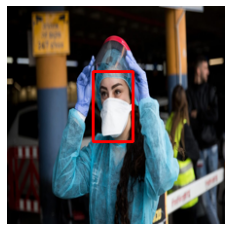

In [7]:
num = 0

image = x_train[num].numpy().astype("uint8")



bounding_box = bounding_boxes_y_train[num].numpy()
label = np.argmax(class_labels_y_train[num].numpy())
print('bounding_box: ', bounding_box)
print('label: ', label)

x_center, y_center = bounding_box[0] * image_size,  bounding_box[1] * image_size
width, height = bounding_box[2] * image_size,  bounding_box[3] * image_size

# Calculate x_min, y_min, x_max, and y_max based on the center coordinates, width/heigth and input size
x_min = int(x_center - (width / 2))
y_min = int( y_center - (height / 2))
x_max = x_min + int(width)
y_max = y_min + int(height)

top_left = (x_min, y_min)
bottom_right = (x_max, y_max)

# Convert image to RGB if it's grayscale
image = np.squeeze(image)  # Remove the extra batch dimension
if len(image.shape) == 2:
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
# Draw rectangles
cv2.rectangle(image, top_left, bottom_right, (255,0,0), 2)
plt.figure(figsize=(4, 4))
plt.imshow(image)
plt.axis("off")
plt.show()

In [8]:
architecture_id = 'base architecture + custom dataset'

In [9]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [10]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    #     Override function to avoid error while saving model
    def get_config(self):
        config = super().get_config().copy()
        config.update(
            {
                "input_shape": input_shape,
                "patch_size": patch_size,
                "num_patches": num_patches,
                "projection_dim": projection_dim,
                "num_heads": num_heads,
                "transformer_units": transformer_units,
                "transformer_layers": transformer_layers,
                "mlp_head_units": mlp_head_units,
            }
        )
        return config

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        # return patches
        return tf.reshape(patches, [batch_size, -1, patches.shape[-1]])

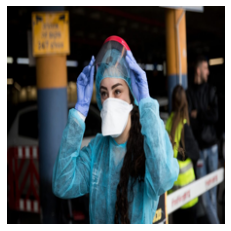

Image size: 224 X 224
Patch size: 32 X 32
49 patches per image 
3072 elements per patch


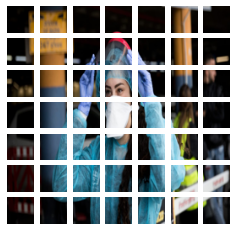

In [11]:
import matplotlib.pyplot as plt

patch_size = 32  # Size of the patches to be extracted from the input images

# Convert the EagerTensor to a NumPy array
x_train_numpy = x_train[0].numpy().astype("uint8")

plt.figure(figsize=(4, 4))
plt.imshow(x_train_numpy)
plt.axis("off")
plt.show()

patches = Patches(patch_size)(tf.convert_to_tensor([x_train_numpy]))
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"{patches.shape[1]} patches per image \n{patches.shape[-1]} elements per patch")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")


In [12]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    # Override function to avoid error while saving model
    def get_config(self):
        config = super().get_config().copy()
        config.update(
            {
                "input_shape": input_shape,
                "patch_size": patch_size,
                "num_patches": num_patches,
                "projection_dim": projection_dim,
                "num_heads": num_heads,
                "transformer_units": transformer_units,
                "transformer_layers": transformer_layers,
                "mlp_head_units": mlp_head_units,
            }
        )
        return config

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [13]:
def create_vit_object_detector(
    input_shape,
    patch_size,
    num_patches,
    projection_dim,
    num_heads,
    transformer_units,
    transformer_layers,
    mlp_head_units,
):
    inputs = layers.Input(shape=input_shape)
    # Create patches
    patches = Patches(patch_size)(inputs)
    # Encode patches
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.3)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.3)

    # Final MLP head for bounding box prediction
    bounding_box = layers.Dense(4, name='bounding_box')(features)

    # Final dense layer for class prediction
    class_predictions = layers.Dense(num_classes, activation='softmax', name='class_predictions')(features)

    # Keras model with both bounding box and class predictions
    model = keras.Model(inputs=inputs, outputs=[bounding_box, class_predictions])

    # return model.
    return model

In [14]:
def calculate_iou(y_true, y_pred):
    intersection = tf.reduce_sum(tf.minimum(y_true, y_pred))
    union = tf.reduce_sum(tf.maximum(y_true, y_pred))
    return intersection / union

In [15]:
folder_count = 0  # type: int
input_path = "vit-model performance"  # type: str
for folders in os.listdir(input_path):  # loop over all files
    if os.path.isdir(os.path.join(input_path, folders)):  # if it's a directory
        folder_count += 1  # increment counter
new_folder = os.path.join(input_path, 'model '+ str(folder_count) + ' - ' + architecture_id)
os.mkdir(new_folder)

Epoch 1/100
30/30 [==============================] - 7s 60ms/step - loss: 0.9564 - bounding_box_loss: 0.2497 - class_predictions_loss: 0.7068 - bounding_box_calculate_iou: 0.3817 - class_predictions_accuracy: 0.5673 - val_loss: 0.7255 - val_bounding_box_loss: 0.0737 - val_class_predictions_loss: 0.6518 - val_bounding_box_calculate_iou: 0.5670 - val_class_predictions_accuracy: 0.7115
Epoch 2/100
30/30 [==============================] - 1s 43ms/step - loss: 0.7784 - bounding_box_loss: 0.1038 - class_predictions_loss: 0.6746 - bounding_box_calculate_iou: 0.5443 - class_predictions_accuracy: 0.6189 - val_loss: 0.6995 - val_bounding_box_loss: 0.0592 - val_class_predictions_loss: 0.6403 - val_bounding_box_calculate_iou: 0.5970 - val_class_predictions_accuracy: 0.7115
Epoch 3/100
30/30 [==============================] - 1s 44ms/step - loss: 0.7402 - bounding_box_loss: 0.0749 - class_predictions_loss: 0.6653 - bounding_box_calculate_iou: 0.6068 - class_predictions_accuracy: 0.6276 - val_loss: 

30/30 [==============================] - 1s 44ms/step - loss: 0.2307 - bounding_box_loss: 0.0326 - class_predictions_loss: 0.1982 - bounding_box_calculate_iou: 0.7590 - class_predictions_accuracy: 0.9300 - val_loss: 0.1624 - val_bounding_box_loss: 0.0194 - val_class_predictions_loss: 0.1430 - val_bounding_box_calculate_iou: 0.8059 - val_class_predictions_accuracy: 0.9327
Epoch 23/100
30/30 [==============================] - 1s 43ms/step - loss: 0.2817 - bounding_box_loss: 0.0330 - class_predictions_loss: 0.2487 - bounding_box_calculate_iou: 0.7639 - class_predictions_accuracy: 0.9053 - val_loss: 0.2949 - val_bounding_box_loss: 0.0154 - val_class_predictions_loss: 0.2795 - val_bounding_box_calculate_iou: 0.8342 - val_class_predictions_accuracy: 0.9038
Epoch 24/100
30/30 [==============================] - 1s 42ms/step - loss: 0.2047 - bounding_box_loss: 0.0322 - class_predictions_loss: 0.1725 - bounding_box_calculate_iou: 0.7542 - class_predictions_accuracy: 0.9279 - val_loss: 0.1671 - v

30/30 [==============================] - 1s 42ms/step - loss: 0.0885 - bounding_box_loss: 0.0192 - class_predictions_loss: 0.0692 - bounding_box_calculate_iou: 0.8149 - class_predictions_accuracy: 0.9752 - val_loss: 0.1642 - val_bounding_box_loss: 0.0140 - val_class_predictions_loss: 0.1502 - val_bounding_box_calculate_iou: 0.8440 - val_class_predictions_accuracy: 0.9327
Epoch 44/100
30/30 [==============================] - 1s 43ms/step - loss: 0.0919 - bounding_box_loss: 0.0198 - class_predictions_loss: 0.0720 - bounding_box_calculate_iou: 0.8148 - class_predictions_accuracy: 0.9731 - val_loss: 0.2451 - val_bounding_box_loss: 0.0141 - val_class_predictions_loss: 0.2310 - val_bounding_box_calculate_iou: 0.8429 - val_class_predictions_accuracy: 0.9423
Epoch 45/100
30/30 [==============================] - 1s 43ms/step - loss: 0.1077 - bounding_box_loss: 0.0175 - class_predictions_loss: 0.0902 - bounding_box_calculate_iou: 0.8211 - class_predictions_accuracy: 0.9699 - val_loss: 0.1887 - v

30/30 [==============================] - 1s 43ms/step - loss: 0.0629 - bounding_box_loss: 0.0177 - class_predictions_loss: 0.0452 - bounding_box_calculate_iou: 0.8199 - class_predictions_accuracy: 0.9882 - val_loss: 0.3924 - val_bounding_box_loss: 0.0139 - val_class_predictions_loss: 0.3784 - val_bounding_box_calculate_iou: 0.8397 - val_class_predictions_accuracy: 0.9135
Epoch 65/100
30/30 [==============================] - 1s 42ms/step - loss: 0.0478 - bounding_box_loss: 0.0155 - class_predictions_loss: 0.0323 - bounding_box_calculate_iou: 0.8333 - class_predictions_accuracy: 0.9871 - val_loss: 0.4829 - val_bounding_box_loss: 0.0145 - val_class_predictions_loss: 0.4684 - val_bounding_box_calculate_iou: 0.8358 - val_class_predictions_accuracy: 0.8942


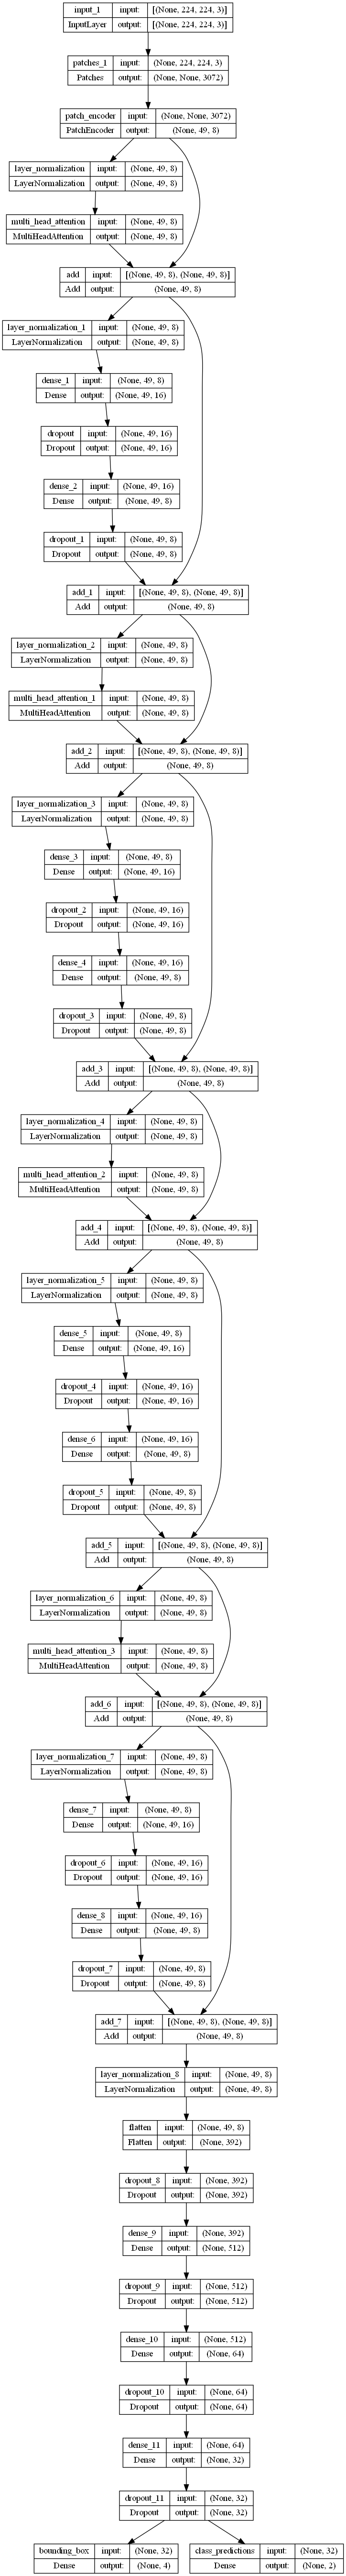

In [16]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image, display
def run_experiment(model, learning_rate, weight_decay, batch_size, num_epochs):

    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )
    
    # Compile the model with appropriate loss functions
    model.compile(
        optimizer='adam',
        loss={'bounding_box': 'mse', 'class_predictions': 'binary_crossentropy'},
        metrics = {'class_predictions' : 'accuracy', 'bounding_box' : calculate_iou }
    )
    
    # Train the model using both bounding_boxes_y and class_labels_y as y-values.
    history = model.fit(
        x = x_train,    # Your training image data
        y = {'bounding_box': bounding_boxes_y_train, 'class_predictions': class_labels_y_train},
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[
            keras.callbacks.EarlyStopping(monitor="val_loss", patience=30),
        ],
    )
    
    dot_img_file = os.path.join(new_folder, 'architecture.png')
    tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)
    display(Image(dot_img_file))
    return history, model



input_shape = (image_size, image_size, 3)  # input image shape
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 32
num_epochs = 100
projection_dim = 8
num_heads = 4
# Size of the transformer layers
transformer_units = [
    projection_dim * 2,
    projection_dim,
]
transformer_layers = 4
mlp_head_units = [512, 64, 32]  # Size of the dense layers


history = []
num_patches = (image_size // patch_size) ** 2

vit_object_detector = create_vit_object_detector(
    input_shape,
    patch_size,
    num_patches,
    projection_dim,
    num_heads,
    transformer_units,
    transformer_layers,
    mlp_head_units,
)

# Train model
history, model = run_experiment(
    vit_object_detector, learning_rate, weight_decay, batch_size, num_epochs
)

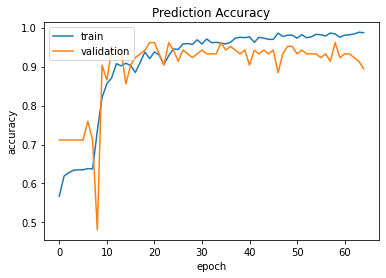

In [17]:
plt.plot(history.history['class_predictions_accuracy'])
plt.plot(history.history['val_class_predictions_accuracy'])
plt.title('Prediction Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
model_file = os.path.join(new_folder, 'class predictions accuracy.png')
plt.savefig(model_file)
plt.show()

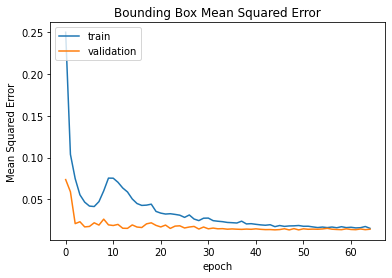

In [18]:
plt.plot(history.history['bounding_box_loss'])
plt.plot(history.history['val_bounding_box_loss'])
plt.title('Bounding Box Mean Squared Error')
plt.ylabel('Mean Squared Error')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
model_file = os.path.join(new_folder, 'bounding box mean squared error.png')
plt.savefig(model_file)
plt.show()

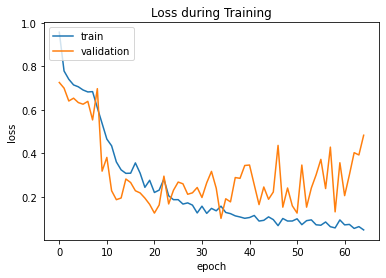

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss during Training')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
model_file = os.path.join(new_folder, 'loss.png')
plt.savefig(model_file,dpi=600, facecolor='w')
plt.show()

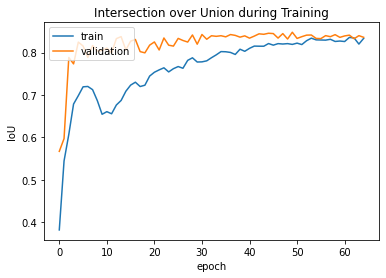

In [20]:
plt.plot(history.history['bounding_box_calculate_iou'])
plt.plot(history.history['val_bounding_box_calculate_iou'])
plt.title('Intersection over Union during Training')
plt.ylabel('IoU')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
model_file = os.path.join(new_folder, 'IoU.png')
plt.savefig(model_file,dpi=600, facecolor='w')
plt.show()


predicted_box_coords:  [0.4626381  0.5171343  0.53899854 0.54948974]
actual_box_coords [0.5515625 0.6016166 0.703125  0.6073903]
predicted_labels:  [1.000000e+00 2.586904e-16]
predicted_label:  0
actual_label:  0
predicted_box_coords:  [0.47700384 0.50057334 0.47526425 0.52974033]
actual_box_coords [0.694 0.537 0.572 0.582]
predicted_labels:  [1.0000000e+00 2.2785276e-09]
predicted_label:  0
actual_label:  0
predicted_box_coords:  [0.463529  0.5071635 0.5022526 0.5377651]
actual_box_coords [0.5604839  0.57857144 0.37580645 0.80285716]
predicted_labels:  [1.0000000e+00 2.3443194e-12]
predicted_label:  0
actual_label:  0
predicted_box_coords:  [0.45973226 0.5099727  0.5212178  0.5400083 ]
actual_box_coords [0.4781818  0.49726775 0.61454546 0.91803277]
predicted_labels:  [1.0000000e+00 5.3248383e-15]
predicted_label:  0
actual_label:  0
predicted_box_coords:  [0.50831324 0.5039476  0.5760229  0.58980274]
actual_box_coords [0.4077381 0.5058548 0.5654762 0.5948478]
predicted_labels:  [2.825

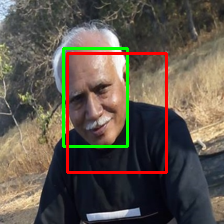

predicted_box_coords:  [0.47818863 0.49915028 0.482843   0.52417576]
actual_box_coords [0.5275229  0.49884528 0.58409786 0.5265589 ]
predicted_labels:  [1.000000e+00 4.813533e-09]
predicted_label:  0
actual_label:  0
predicted_box_coords:  [0.49190402 0.47505835 0.5956341  0.58931327]
actual_box_coords [0.5359375  0.5277136  0.628125   0.66281754]
predicted_labels:  [6.5792024e-14 1.0000000e+00]
predicted_label:  1
actual_label:  1
predicted_box_coords:  [0.4865929  0.49855453 0.47002417 0.52359   ]
actual_box_coords [0.48554912 0.5361991  0.56647396 0.5565611 ]
predicted_labels:  [1.0000000e+00 1.1911564e-08]
predicted_label:  0
actual_label:  0
predicted_box_coords:  [0.48498154 0.4769109  0.59152746 0.5863672 ]
actual_box_coords [0.5152905  0.49884528 0.5657492  0.6605081 ]
predicted_labels:  [1.1670298e-13 1.0000000e+00]
predicted_label:  1
actual_label:  1
predicted_box_coords:  [0.47765368 0.4963894  0.45900774 0.52445114]
actual_box_coords [0.528125 0.48125  0.41375  0.46    ]
p

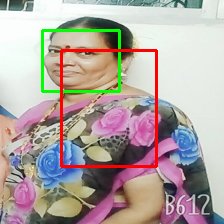

predicted_box_coords:  [0.49269402 0.49665913 0.4721766  0.52096796]
actual_box_coords [0.58416665 0.5659375  0.5183333  0.546875  ]
predicted_labels:  [9.9999976e-01 1.8844761e-07]
predicted_label:  0
actual_label:  0
predicted_box_coords:  [0.5096586  0.50842226 0.5817257  0.5945283 ]
actual_box_coords [0.52678573 0.42291668 0.41964287 0.4375    ]
predicted_labels:  [2.9551044e-08 1.0000000e+00]
predicted_label:  1
actual_label:  1
predicted_box_coords:  [0.46658736 0.51158065 0.513367   0.5402244 ]
actual_box_coords [0.45625    0.62266356 0.59375    0.53504676]
predicted_labels:  [1.0000000e+00 8.0895213e-13]
predicted_label:  0
actual_label:  0
predicted_box_coords:  [0.5197674  0.48597234 0.63865256 0.6195773 ]
actual_box_coords [0.4526699  0.5578842  0.6237864  0.71257484]
predicted_labels:  [2.912341e-17 1.000000e+00]
predicted_label:  1
actual_label:  1
predicted_box_coords:  [0.4578219  0.51354265 0.53670776 0.5462719 ]
actual_box_coords [0.46498054 0.5382653  0.68871593 0.913

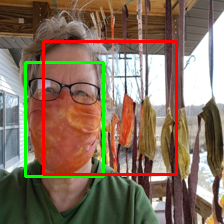

predicted_box_coords:  [0.4741674  0.49870238 0.45984197 0.52382594]
actual_box_coords [0.4092664  0.52820516 0.4092664  0.5641026 ]
predicted_labels:  [1.0000e+00 1.8584e-09]
predicted_label:  0
actual_label:  0
predicted_box_coords:  [0.5048664  0.49993992 0.6022856  0.6099429 ]
actual_box_coords [0.49481866 0.5421456  0.68911916 0.7241379 ]
predicted_labels:  [3.4527273e-11 1.0000000e+00]
predicted_label:  1
actual_label:  1
predicted_box_coords:  [0.4638636  0.5136041  0.52356005 0.5449258 ]
actual_box_coords [0.55      0.5490654 0.64375   0.6168224]
predicted_labels:  [1.000000e+00 9.127713e-15]
predicted_label:  0
actual_label:  0
predicted_box_coords:  [0.5018418  0.49008417 0.45736277 0.51597947]
actual_box_coords [0.29666665 0.375      0.39333335 0.51666665]
predicted_labels:  [0.98992234 0.01007765]
predicted_label:  0
actual_label:  0
predicted_box_coords:  [0.48956043 0.47634184 0.6005241  0.5929989 ]
actual_box_coords [0.42332268 0.53900707 0.5782748  0.6004728 ]
predicted

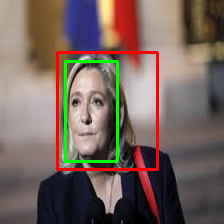

predicted_box_coords:  [0.4955372  0.4880033  0.40403277 0.51045054]
actual_box_coords [0.56349206 0.35338345 0.4814815  0.48872182]
predicted_labels:  [9.9997318e-01 2.6844313e-05]
predicted_label:  0
actual_label:  1


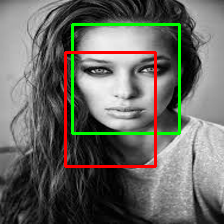

predicted_box_coords:  [0.49664724 0.478787   0.41433877 0.49353367]
actual_box_coords [0.484375   0.4633968  0.10351562 0.16251831]
predicted_labels:  [9.9999952e-01 4.5978584e-07]
predicted_label:  0
actual_label:  0
predicted_box_coords:  [0.5448918  0.43128568 0.4794947  0.5501299 ]
actual_box_coords [0.40416667 0.36484376 0.48333332 0.3390625 ]
predicted_labels:  [1.1888475e-04 9.9988115e-01]
predicted_label:  1
actual_label:  0


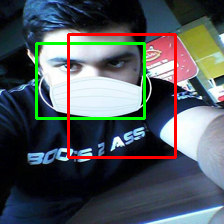

predicted_box_coords:  [0.49682403 0.47585505 0.4002135  0.4922619 ]
actual_box_coords [0.5234375  0.4340278  0.15625    0.27083334]
predicted_labels:  [9.9999809e-01 1.8661035e-06]
predicted_label:  0
actual_label:  0
predicted_box_coords:  [0.49622527 0.48429334 0.60081387 0.5968677 ]
actual_box_coords [0.51111114 0.50666666 0.56       0.8       ]
predicted_labels:  [2.5696814e-13 1.0000000e+00]
predicted_label:  1
actual_label:  1
predicted_box_coords:  [0.46544164 0.49993995 0.4846059  0.52762026]
actual_box_coords [0.44916666 0.56166667 0.32666665 0.445     ]
predicted_labels:  [1.0000000e+00 6.3410453e-12]
predicted_label:  0
actual_label:  0
predicted_box_coords:  [0.51312375 0.50788844 0.5572146  0.5806442 ]
actual_box_coords [0.52675587 0.5976331  0.34448162 0.6745562 ]
predicted_labels:  [1.953667e-06 9.999981e-01]
predicted_label:  1
actual_label:  1
predicted_box_coords:  [0.4989052 0.4806721 0.6141355 0.6024604]
actual_box_coords [0.5453125 0.5268692 0.721875  0.5911215]
p

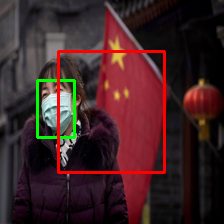

predicted_box_coords:  [0.52415955 0.5030185  0.520973   0.55090106]
actual_box_coords [0.5        0.34854773 0.37724552 0.373444  ]
predicted_labels:  [2.8779508e-05 9.9997127e-01]
predicted_label:  1
actual_label:  1
predicted_box_coords:  [0.49659488 0.500406   0.4683383  0.5283446 ]
actual_box_coords [0.49250534 0.4485714  0.6167024  0.51428574]
predicted_labels:  [0.9756345  0.02436548]
predicted_label:  0
actual_label:  0
predicted_box_coords:  [0.4906266  0.4842271  0.43371773 0.5071813 ]
actual_box_coords [0.4078125  0.13489583 0.18125    0.134375  ]
predicted_labels:  [9.999994e-01 6.483413e-07]
predicted_label:  0
actual_label:  0
predicted_box_coords:  [0.5224014  0.49709836 0.4996655  0.5451751 ]
actual_box_coords [0.6145     0.25466666 0.243      0.32      ]
predicted_labels:  [4.9459054e-06 9.9999511e-01]
predicted_label:  1
actual_label:  0


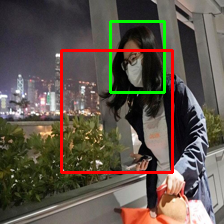

predicted_box_coords:  [0.48027968 0.47864446 0.55869067 0.56308216]
actual_box_coords [0.4648094  0.4890351  0.61876833 0.60087717]
predicted_labels:  [4.2175e-09 1.0000e+00]
predicted_label:  1
actual_label:  1
predicted_box_coords:  [0.5032577  0.4946665  0.42572254 0.53023434]
actual_box_coords [0.49722221 0.35520834 0.37592593 0.23958333]
predicted_labels:  [0.99787295 0.00212704]
predicted_label:  0
actual_label:  0
predicted_box_coords:  [0.50976676 0.49217147 0.63501203 0.620403  ]
actual_box_coords [0.5765625  0.47897196 0.640625   0.6401869 ]
predicted_labels:  [5.07048e-16 1.00000e+00]
predicted_label:  1
actual_label:  1
predicted_box_coords:  [0.46543562 0.5114942  0.5055216  0.53698575]
actual_box_coords [0.52307695 0.48711342 0.33076924 0.48969072]
predicted_labels:  [1.0000000e+00 1.5296499e-12]
predicted_label:  0
actual_label:  0
predicted_box_coords:  [0.5066977  0.49645835 0.4573366  0.54214567]
actual_box_coords [0.33268103 0.40120968 0.42270058 0.53629035]
predict

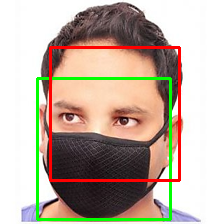

predicted_box_coords:  [0.48751977 0.4968804  0.46421194 0.5240875 ]
actual_box_coords [0.5575   0.388125 0.345    0.42875 ]
predicted_labels:  [9.999999e-01 7.536485e-08]
predicted_label:  0
actual_label:  0
predicted_box_coords:  [0.48109406 0.4957004  0.44843537 0.5232167 ]
actual_box_coords [0.548      0.47580644 0.472      0.47419354]
predicted_labels:  [1.0000000e+00 3.9059866e-08]
predicted_label:  0
actual_label:  0
predicted_box_coords:  [0.48592943 0.4969496  0.47213307 0.52490044]
actual_box_coords [0.4811321  0.58641976 0.44339624 0.61975306]
predicted_labels:  [1.0000000e+00 3.3840912e-08]
predicted_label:  0
actual_label:  0
predicted_box_coords:  [0.50182396 0.4900037  0.450059   0.51998293]
actual_box_coords [0.51       0.5635593  0.47142857 0.5       ]
predicted_labels:  [9.9995053e-01 4.9438673e-05]
predicted_label:  0
actual_label:  0
predicted_box_coords:  [0.5140797  0.48244527 0.60978997 0.60203135]
actual_box_coords [0.528125  0.5230947 0.6       0.5935335]
predi

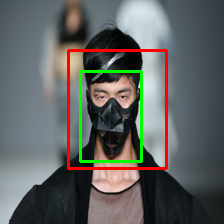

predicted_box_coords:  [0.5042379  0.49634182 0.44421983 0.52568   ]
actual_box_coords [0.45041323 0.52818626 0.46005508 0.41911766]
predicted_labels:  [9.999521e-01 4.794414e-05]
predicted_label:  0
actual_label:  0
predicted_box_coords:  [0.4575588  0.51518285 0.5409845  0.5481116 ]
actual_box_coords [0.5425926  0.54605263 0.6037037  0.8815789 ]
predicted_labels:  [1.0000000e+00 7.3928796e-18]
predicted_label:  0
actual_label:  0
predicted_box_coords:  [0.5064426  0.4969949  0.44907472 0.5303559 ]
actual_box_coords [0.6761719  0.38789025 0.26484376 0.39545885]
predicted_labels:  [9.999337e-01 6.631672e-05]
predicted_label:  0
actual_label:  0
predicted_box_coords:  [0.49564242 0.4786691  0.6051245  0.5965122 ]
actual_box_coords [0.50625    0.5630841  0.6375     0.60747665]
predicted_labels:  [3.464489e-15 1.000000e+00]
predicted_label:  1
actual_label:  1
predicted_box_coords:  [0.49901545 0.49543548 0.43391335 0.5338886 ]
actual_box_coords [0.539      0.47933334 0.51       0.6      

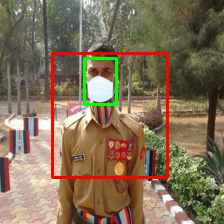

predicted_box_coords:  [0.50550073 0.5009987  0.4333075  0.5368619 ]
actual_box_coords [0.5190972  0.34895834 0.2986111  0.25      ]
predicted_labels:  [0.9947819  0.00521804]
predicted_label:  0
actual_label:  1


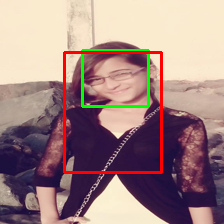

predicted_box_coords:  [0.49800727 0.48330724 0.5952076  0.5974167 ]
actual_box_coords [0.553125  0.5759346 0.6125    0.5957944]
predicted_labels:  [1.8085322e-12 1.0000000e+00]
predicted_label:  1
actual_label:  1
predicted_box_coords:  [0.45762962 0.5181182  0.5523827  0.5543667 ]
actual_box_coords [0.49722221 0.4814815  0.6759259  0.9382716 ]
predicted_labels:  [1.000000e+00 1.295778e-19]
predicted_label:  0
actual_label:  0
predicted_box_coords:  [0.5117294  0.5088999  0.49929225 0.54806393]
actual_box_coords [0.69899666 0.4077381  0.4147157  0.76785713]
predicted_labels:  [0.00678332 0.9932167 ]
predicted_label:  1
actual_label:  1
predicted_box_coords:  [0.5075165  0.49267453 0.6159142  0.6115851 ]
actual_box_coords [0.5379061  0.4432099  0.55595666 0.51111114]
predicted_labels:  [4.1629376e-13 1.0000000e+00]
predicted_label:  1
actual_label:  1
predicted_box_coords:  [0.4777037  0.5075409  0.48925537 0.5365461 ]
actual_box_coords [0.3859649 0.6099291 0.7017544 0.5673759]
predict

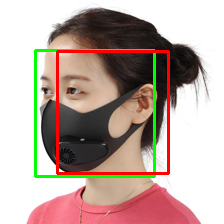

predicted_box_coords:  [0.5037373  0.4914474  0.44279262 0.5214338 ]
actual_box_coords [0.55583334 0.5208333  0.315      0.435     ]
predicted_labels:  [9.9971765e-01 2.8236528e-04]
predicted_label:  0
actual_label:  0
predicted_box_coords:  [0.47487402 0.4659635  0.57200164 0.5665697 ]
actual_box_coords [0.48402557 0.5541761  0.686901   0.6343115 ]
predicted_labels:  [9.978523e-13 1.000000e+00]
predicted_label:  1
actual_label:  1
predicted_box_coords:  [0.47561115 0.49164593 0.46148682 0.5092247 ]
actual_box_coords [0.697807   0.32982457 0.3219298  0.55438596]
predicted_labels:  [1.0000000e+00 2.5932516e-09]
predicted_label:  0
actual_label:  0
predicted_box_coords:  [0.48907542 0.47204447 0.60829043 0.5934411 ]
actual_box_coords [0.521875   0.53971964 0.675      0.682243  ]
predicted_labels:  [9.3988885e-18 1.0000000e+00]
predicted_label:  1
actual_label:  1
predicted_box_coords:  [0.48527825 0.46655488 0.59100866 0.5803345 ]
actual_box_coords [0.5714286  0.5155039  0.7089947  0.829

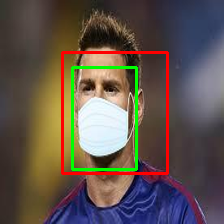

predicted_box_coords:  [0.5306131 0.4948207 0.4801942 0.5272119]
actual_box_coords [0.5176471 0.6130653 0.5905882 0.6311558]
predicted_labels:  [2.1060034e-04 9.9978942e-01]
predicted_label:  1
actual_label:  0


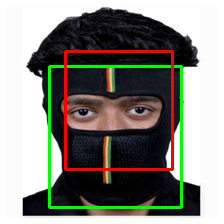

predicted_box_coords:  [0.4644243 0.5178504 0.5313421 0.5475071]
actual_box_coords [0.46875    0.56658876 0.575      0.567757  ]
predicted_labels:  [1.0000000e+00 2.4420305e-15]
predicted_label:  0
actual_label:  0
predicted_box_coords:  [0.51064986 0.47833878 0.63043773 0.61269665]
actual_box_coords [0.52472526 0.5416667  0.6978022  0.6702899 ]
predicted_labels:  [2.0182194e-18 1.0000000e+00]
predicted_label:  1
actual_label:  1
predicted_box_coords:  [0.5116699  0.5123477  0.5470322  0.57383883]
actual_box_coords [0.4032258  0.49202734 0.29032257 0.4328018 ]
predicted_labels:  [3.9645961e-06 9.9999607e-01]
predicted_label:  1
actual_label:  1
predicted_box_coords:  [0.4644604  0.5129961  0.5220283  0.54155004]
actual_box_coords [0.4890625  0.5692841  0.653125   0.53810626]
predicted_labels:  [1.0000000e+00 2.7146459e-14]
predicted_label:  0
actual_label:  0
predicted_box_coords:  [0.4874484  0.47291878 0.6059964  0.58870685]
actual_box_coords [0.4875     0.47079438 0.6125     0.67990

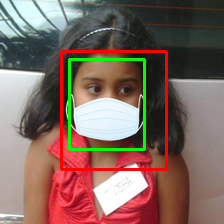

predicted_box_coords:  [0.4997826  0.491382   0.42824173 0.52130103]
actual_box_coords [0.52       0.32833335 0.31333333 0.33666667]
predicted_labels:  [9.9993074e-01 6.9273279e-05]
predicted_label:  0
actual_label:  0
predicted_box_coords:  [0.47178537 0.5137478  0.5128231  0.54189175]
actual_box_coords [0.54587156 0.5669746  0.57186544 0.556582  ]
predicted_labels:  [1.0000000e+00 1.1915176e-12]
predicted_label:  0
actual_label:  0
predicted_box_coords:  [0.46497136 0.51217127 0.51875013 0.5401078 ]
actual_box_coords [0.54993254 0.55862534 0.560054   0.5161725 ]
predicted_labels:  [1.0000000e+00 5.3278887e-14]
predicted_label:  0
actual_label:  0
predicted_box_coords:  [0.49956077 0.49448857 0.4387071  0.5213545 ]
actual_box_coords [0.536875   0.61904764 0.30625    0.7047619 ]
predicted_labels:  [0.4605454 0.5394546]
predicted_label:  1
actual_label:  0


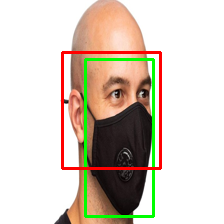

predicted_box_coords:  [0.46166041 0.5158001  0.5346911  0.5474372 ]
actual_box_coords [0.465625   0.58545035 0.5875     0.49191687]
predicted_labels:  [1.0000000e+00 4.6867805e-16]
predicted_label:  0
actual_label:  0
predicted_box_coords:  [0.47365308 0.49739805 0.46833417 0.5225032 ]
actual_box_coords [0.54173106 0.41212872 0.3724884  0.6410891 ]
predicted_labels:  [1.00000e+00 4.40924e-10]
predicted_label:  0
actual_label:  0
predicted_box_coords:  [0.526024   0.4928534  0.44863248 0.5273089 ]
actual_box_coords [0.4827586  0.40987125 0.36453202 0.40772533]
predicted_labels:  [0.38170347 0.6182966 ]
predicted_label:  1
actual_label:  1
predicted_box_coords:  [0.46330112 0.51626754 0.528648   0.54757357]
actual_box_coords [0.5578125  0.59345794 0.684375   0.59345794]
predicted_labels:  [1.000000e+00 4.546417e-15]
predicted_label:  0
actual_label:  0
predicted_box_coords:  [0.49112517 0.48415685 0.59169126 0.59024876]
actual_box_coords [0.4859375  0.51501155 0.609375   0.6096998 ]
pre

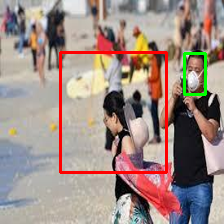

predicted_box_coords:  [0.46922004 0.5102136  0.5066999  0.5412461 ]
actual_box_coords [0.48929664 0.5334873  0.6238532  0.5588915 ]
predicted_labels:  [1.000000e+00 3.074569e-12]
predicted_label:  0
actual_label:  0
predicted_box_coords:  [0.46958387 0.5063343  0.49675542 0.53379405]
actual_box_coords [0.48514852 0.5060241  0.46534654 0.4176707 ]
predicted_labels:  [1.0000000e+00 2.2682141e-11]
predicted_label:  0
actual_label:  0
predicted_box_coords:  [0.51404417 0.4974116  0.5586299  0.57541984]
actual_box_coords [0.5217391  0.35948905 0.41304347 0.4270073 ]
predicted_labels:  [1.644205e-08 1.000000e+00]
predicted_label:  1
actual_label:  1
predicted_box_coords:  [0.516475   0.49150062 0.55207956 0.57245517]
actual_box_coords [0.48029557 0.33064517 0.2413793  0.21774194]
predicted_labels:  [7.242347e-09 1.000000e+00]
predicted_label:  1
actual_label:  0


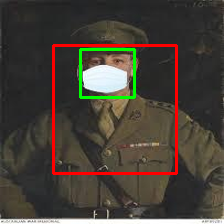

predicted_box_coords:  [0.48950428 0.49137855 0.4459757  0.51962084]
actual_box_coords [0.552  0.4235 0.35   0.415 ]
predicted_labels:  [9.9999917e-01 7.7510930e-07]
predicted_label:  0
actual_label:  0
predicted_box_coords:  [0.4732125  0.50317127 0.48925522 0.52915925]
actual_box_coords [0.51     0.515625 0.49     0.62125 ]
predicted_labels:  [1.00000e+00 5.92387e-11]
predicted_label:  0
actual_label:  0
predicted_box_coords:  [0.46235532 0.51703215 0.5358026  0.5487281 ]
actual_box_coords [0.5515625  0.60864484 0.690625   0.55841124]
predicted_labels:  [1.000000e+00 6.472786e-16]
predicted_label:  0
actual_label:  0
predicted_box_coords:  [0.49070042 0.47513792 0.6032549  0.5921672 ]
actual_box_coords [0.496875   0.52424943 0.6        0.60508084]
predicted_labels:  [6.9291234e-16 1.0000000e+00]
predicted_label:  1
actual_label:  1
predicted_box_coords:  [0.49698156 0.48378628 0.46462303 0.50905216]
actual_box_coords [0.5873016  0.6143411  0.67724866 0.7093023 ]
predicted_labels:  [9

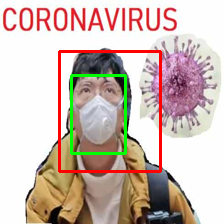

predicted_box_coords:  [0.47654545 0.5085779  0.49507305 0.5363427 ]
actual_box_coords [0.4902439  0.54285717 0.46829268 0.6       ]
predicted_labels:  [1.00000000e+00 1.00966964e-10]
predicted_label:  0
actual_label:  0
predicted_box_coords:  [0.49778026 0.48453516 0.44502664 0.52820164]
actual_box_coords [0.53208554 0.36699507 0.4117647  0.4679803 ]
predicted_labels:  [0.34195864 0.65804136]
predicted_label:  1
actual_label:  1
predicted_box_coords:  [0.51243305 0.47776318 0.5047995  0.53526485]
actual_box_coords [0.3885135  0.37112403 0.35540542 0.5096899 ]
predicted_labels:  [1.6329029e-06 9.9999833e-01]
predicted_label:  1
actual_label:  1
predicted_box_coords:  [0.46146464 0.5168597  0.5400126  0.55089235]
actual_box_coords [0.49253732 0.5795848  0.6766169  0.51557094]
predicted_labels:  [1.0000000e+00 1.5189246e-16]
predicted_label:  0
actual_label:  0
predicted_box_coords:  [0.5047583  0.50196487 0.5752618  0.5873293 ]
actual_box_coords [0.41339868 0.4556962  0.5130719  0.52658

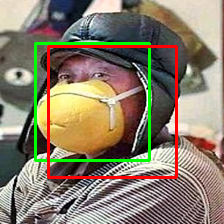

predicted_box_coords:  [0.46721974 0.5103588  0.5103916  0.539673  ]
actual_box_coords [0.5546875 0.5771028 0.615625  0.5233645]
predicted_labels:  [1.000000e+00 1.006932e-12]
predicted_label:  0
actual_label:  0
predicted_box_coords:  [0.46746704 0.5103494  0.5137118  0.5393051 ]
actual_box_coords [0.5353516  0.6024306  0.3371094  0.58402777]
predicted_labels:  [1.0000000e+00 1.1606174e-12]
predicted_label:  0
actual_label:  0
predicted_box_coords:  [0.46348584 0.5048231  0.49711466 0.53093547]
actual_box_coords [0.67673266 0.5529703  0.5079208  0.65643567]
predicted_labels:  [1.0000000e+00 1.3572124e-12]
predicted_label:  0
actual_label:  0
predicted_box_coords:  [0.4918139  0.49157742 0.45114145 0.51915514]
actual_box_coords [0.34833333 0.66964287 0.28333333 0.57738096]
predicted_labels:  [9.9999881e-01 1.1700404e-06]
predicted_label:  0
actual_label:  0
predicted_box_coords:  [0.4816823  0.49041522 0.43575168 0.5301152 ]
actual_box_coords [0.5112045  0.41404012 0.34453782 0.4212034

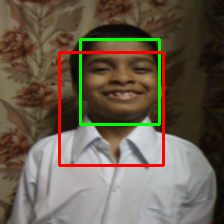

predicted_box_coords:  [0.50904423 0.48945263 0.56003225 0.5760255 ]
actual_box_coords [0.3216146 0.240625  0.6432292 0.475    ]
predicted_labels:  [3.3712177e-09 1.0000000e+00]
predicted_label:  1
actual_label:  1
predicted_box_coords:  [0.5133548  0.49347386 0.43779957 0.5331127 ]
actual_box_coords [0.5402439  0.47804877 0.42439026 0.43658537]
predicted_labels:  [0.01689162 0.98310834]
predicted_label:  1
actual_label:  0


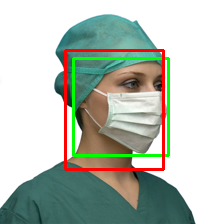

predicted_box_coords:  [0.4967788  0.51191664 0.53400815 0.5654353 ]
actual_box_coords [0.51132077 0.5308642  0.41886792 0.6617284 ]
predicted_labels:  [2.8631146e-04 9.9971372e-01]
predicted_label:  1
actual_label:  0


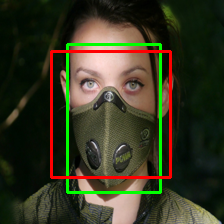

predicted_box_coords:  [0.47900316 0.47237936 0.4167678  0.4832665 ]
actual_box_coords [0.43945312 0.32899305 0.2421875  0.49131945]
predicted_labels:  [1.0000000e+00 2.5809597e-09]
predicted_label:  0
actual_label:  0
predicted_box_coords:  [0.5013585 0.4881146 0.6162964 0.6088991]
actual_box_coords [0.528125   0.50233644 0.6        0.59345794]
predicted_labels:  [4.179643e-14 1.000000e+00]
predicted_label:  1
actual_label:  1
predicted_box_coords:  [0.48846117 0.49120164 0.44947746 0.51766384]
actual_box_coords [0.49272728 0.42896175 0.17818181 0.30054644]
predicted_labels:  [9.9999785e-01 2.1906187e-06]
predicted_label:  0
actual_label:  0
predicted_box_coords:  [0.51464593 0.5106347  0.5241596  0.55993736]
actual_box_coords [0.5037037  0.61992264 0.5876543  0.63249516]
predicted_labels:  [7.640927e-05 9.999236e-01]
predicted_label:  1
actual_label:  1
predicted_box_coords:  [0.48282546 0.4680972  0.60742944 0.5935426 ]
actual_box_coords [0.45118344 0.5530474  0.71301776 0.64108354]

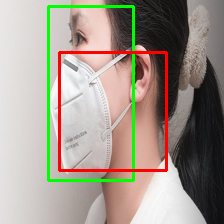

predicted_box_coords:  [0.5077465  0.49461502 0.58402085 0.5930929 ]
actual_box_coords [0.459375   0.5478972  0.675      0.64719623]
predicted_labels:  [3.2490372e-10 1.0000000e+00]
predicted_label:  1
actual_label:  1
predicted_box_coords:  [0.4745568  0.49875736 0.4723389  0.5275584 ]
actual_box_coords [0.5625     0.204375   0.22833334 0.35375   ]
predicted_labels:  [1.0000000e+00 2.1153232e-09]
predicted_label:  0
actual_label:  0
predicted_box_coords:  [0.46303973 0.51389194 0.5290157  0.546467  ]
actual_box_coords [0.546875  0.6051402 0.60625   0.5420561]
predicted_labels:  [1.0000000e+00 1.0177845e-14]
predicted_label:  0
actual_label:  0
predicted_box_coords:  [0.51000553 0.5025557  0.5905631  0.6051247 ]
actual_box_coords [0.5578125  0.5525701  0.628125   0.61915886]
predicted_labels:  [4.7017834e-10 1.0000000e+00]
predicted_label:  1
actual_label:  1
predicted_box_coords:  [0.48211563 0.46795824 0.567576   0.56680316]
actual_box_coords [0.40264025 0.4548193  0.5280528  0.89759

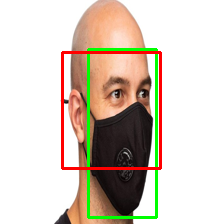

predicted_box_coords:  [0.46383193 0.5054266  0.49223033 0.52698684]
actual_box_coords [0.49583334 0.428125   0.26666668 0.234375  ]
predicted_labels:  [1.0000000e+00 6.3165766e-12]
predicted_label:  0
actual_label:  0
predicted_box_coords:  [0.5100969 0.4972368 0.530981  0.5664925]
actual_box_coords [0.52459013 0.3272727  0.3387978  0.29090908]
predicted_labels:  [1.0816525e-06 9.9999893e-01]
predicted_label:  1
actual_label:  0


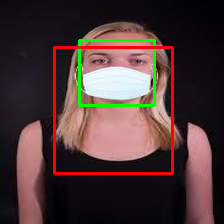

predicted_box_coords:  [0.48616943 0.48538646 0.4355576  0.512612  ]
actual_box_coords [0.49939024 0.50731707 0.40853658 0.45365855]
predicted_labels:  [9.9999917e-01 8.3908782e-07]
predicted_label:  0
actual_label:  0
predicted_box_coords:  [0.4624442  0.5149255  0.5303029  0.54644847]
actual_box_coords [0.5125     0.58995324 0.6        0.5303738 ]
predicted_labels:  [1.0000000e+00 2.3011662e-15]
predicted_label:  0
actual_label:  0
predicted_box_coords:  [0.4813276 0.4943791 0.4643417 0.518406 ]
actual_box_coords [0.48645833 0.41015625 0.23541667 0.2609375 ]
predicted_labels:  [1.000000e+00 3.347148e-08]
predicted_label:  0
actual_label:  1


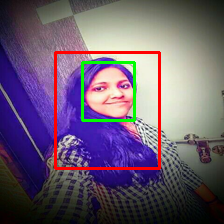

In [23]:
from IPython.display import display
from PIL import Image
for i in range(0, len(x_test)):
    image = x_test[i].numpy().astype("uint8")
    # Add an additional dimension for batch size
    image = np.expand_dims(image, axis=0)
    x_center_actual = bounding_boxes_y_test[i][0] * image_size
    y_center_actual = bounding_boxes_y_test[i][1] * image_size
    width_actual = bounding_boxes_y_test[i][2] * image_size
    height_actual = bounding_boxes_y_test[i][3] * image_size

    # Calculate x_min, y_min, x_max, and y_max based on the center coordinates, width/heigth and input size
    x_min_actual = int(x_center_actual - (width_actual / 2))
    y_min_actual = int( y_center_actual - (height_actual / 2))
    x_max_actual = x_min_actual + int(width_actual)
    y_max_actual = y_min_actual + int(height_actual)

    top_left_actual = (x_min_actual, y_min_actual)
    bottom_right_actual = (x_max_actual, y_max_actual)




    predictions = model(image)


    # Extract the bounding box center coordinates from predictions
    predicted_box_coords = predictions[0].numpy()[0]
    x_center, y_center = predicted_box_coords[0] * image_size,  predicted_box_coords[1] * image_size
    width, height = predicted_box_coords[2] * image_size,  predicted_box_coords[3] * image_size

    #Extract the prediction label
    predicted_labels = predictions[1].numpy()[0]
    #print('predicted_labels: ', predicted_labels)
    predicted_label =  np.argmax(predicted_labels)
    actual_label =  np.argmax(class_labels_y_test[i].numpy())
    
    # Calculate x_min, y_min, x_max, and y_max based on the center coordinates, width/heigth and input size
    x_min = int(x_center - (width / 2))
    y_min = int( y_center - (height / 2))
    x_max = x_min + int(width)
    y_max = y_min + int(height)

    top_left = (x_min, y_min)
    bottom_right = (x_max, y_max)

    # Convert image to RGB if it's grayscale
    image = np.squeeze(image)  # Remove the extra batch dimension
    if len(image.shape) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    # Now use the tuple coordinates in the cv2.rectangle function
    color = (0, 255, 0)  # Set green for actual
    # Draw rectangles
    image = cv2.rectangle(image, top_left_actual, bottom_right_actual, color, 2)
    color = (255, 0, 0)  # Set red for prediction
    # Draw rectangles
    cv2.rectangle(image, top_left, bottom_right, color, 2)
    
    if actual_label != predicted_label:
        print('predicted_box_coords: ', predicted_box_coords)
        print('actual_box_coords', bounding_boxes_y_test[i].numpy())
        print('predicted_label: ', predicted_label)
        print('actual_label: ', actual_label)
        # Convert the numpy array to a PIL Image
        image_pil = Image.fromarray(image)
        # Display the image and make it persist
        display(image_pil)